# Load data

In [1]:
import sys
sys.path.append('../flwrapp')

In [2]:
import datasets
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from dentalData.Pipelines import entire_data_processing_pipeline

c:\Users\Bruger\Desktop\Bachelor-Project---Federated-Incremental-Learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'dentalData'

In [ ]:
ds = entire_data_processing_pipeline(sys.path[-1])

Data with two categories is imported
id TR21
timestamp start 09-04-2025 19-32-41
timestamp end 
n_categories 2
original data size (5593, 98)
previous values no


c:\Users\Bruger\Desktop\BachelorProject---A-Federated-Learning-Approach-to-JIA\mlNotebooks\../flwrapp\dentalData\FeatureEngineering\RightLeftTransformation.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[featureNameMerged] = mergedList
c:\Users\Bruger\Desktop\BachelorProject---A-Federated-Learning-Approach-to-JIA\mlNotebooks\../flwrapp\dentalData\FeatureEngineering\RightLeftTransformation.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[featureNameMerged] = mergedList
c:\Users\Bruger\Desktop\BachelorProjec

Merging of features is done
encoding one hot
encoded data size (5593, 116)
Data encoded
Data normalized
data=      index  sex  ageatvisitation  difftdate  activity  morningstiffness  \
0         0    1        10.067077   0.000000         1                 0   
1         1    0         8.180698   0.000000         0                 0   
2         2    1         8.783025   0.000000         0                 0   
3         3    0         4.112252   0.000000         1                 0   
4         4    1         5.295003   0.000000         0                 0   
...     ...  ...              ...        ...       ...               ...   
5588   6000    1        16.689938  13.932923         1                 0   
5589   6001    1        16.134155  11.633128         0                 0   
5590   6003    1        17.719370  14.105407         0                 0   
5591   6005    1        17.817933  14.031485         0                 0   
5592   6010    1        17.092402  14.335387         0 

c:\Users\Bruger\Desktop\BachelorProject---A-Federated-Learning-Approach-to-JIA\.venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [ ]:
X, y = np.array(ds['features']), np.array(ds['labels'])

X = np.array(X, dtype=float)
y = np.array(y, dtype=float)

In [ ]:
def kFoldCrossValidationSplit(X, y, k = 5):
    # TODO: Maybe add shuffling before splitting
    segmentSize = X.shape[0] // k
    segmentations = []
    for i in range(k):
        start = i * segmentSize
        end = (i+1) * segmentSize
        segmentation = {
            "X_train": np.concatenate([X[:start, :], X[end:, :]]),
            "y_train": np.concatenate([y[:start], y[end:]]),
            "X_test": X[start:end],
            "y_test": y[start:end],
        }
        segmentations.append(segmentation)
    return segmentations
        
# Set k for the fold crossvalidation

k = 5

segmentations = kFoldCrossValidationSplit(X, y, k)

segmentations[0]["y_train"].shape

(4475,)

In [ ]:
def createSubTrainsets(segmentations: list):
    splitSegmentations = []
    for segmentation in segmentations:
        train_len = segmentation["X_train"].shape[0]
        splitSegmentation = {
            "X_train_10p": segmentation["X_train"][:int(0.1*train_len)],
            "y_train_10p": segmentation["y_train"][:int(0.1*train_len)],
            "X_train_50p": segmentation["X_train"][:int(0.5*train_len)],
            "y_train_50p": segmentation["y_train"][:int(0.5*train_len)],
            "X_train_100p": segmentation["X_train"],
            "y_train_100p": segmentation["y_train"],
            "X_test_total": segmentation["X_test"],
            "y_test_total": segmentation["y_test"],
        }
        splitSegmentations.append(splitSegmentation)
    return splitSegmentations

splitSegmentations = createSubTrainsets(segmentations)

splitSegmentations[0]['X_train_10p'].shape, np.mean(splitSegmentations[0]['y_train_100p'])

((447, 115), np.float64(0.383463687150838))

# Function for creating dataloaders

In [ ]:
def convertToDataloaders(trainSets, testSets):
    # Define collate function for making list into stacked pytorch tensor
    def collate_fn(batch):
        features = torch.tensor([item['features'] for item in batch])
        labels = torch.tensor([item['labels'] for item in batch])
        return {'features': features, 'labels': labels}

    trainloaders = []
    for trainset in trainSets:
        trainloaders.append(DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate_fn))

    testloaders = []
    for testset in testSets:
        testloaders.append(DataLoader(testset, batch_size=32, shuffle=True, collate_fn=collate_fn))
    return trainloaders, testloaders

In [ ]:
def createDataLoader(segmentation):
    trainsets = [
        datasets.Dataset.from_dict(
            {
                "features": segmentation["X_train_10p"],
                "labels": segmentation["y_train_10p"],
            }
        ),
        datasets.Dataset.from_dict(
            {
                "features": segmentation["X_train_50p"],
                "labels": segmentation["y_train_50p"],
            }
        ),
        datasets.Dataset.from_dict(
            {
                "features": segmentation["X_train_100p"],
                "labels": segmentation["y_train_100p"],
            }
        ),
    ]

    testSets = [
        datasets.Dataset.from_dict(
            {"features": segmentation["X_test_total"], "labels": segmentation["y_test_total"]}
        ),
    ]

    trainloaders, testloaders = convertToDataloaders(trainsets, testSets)
    trainloader10p = trainloaders[0]
    trainloader50p = trainloaders[1]
    trainloader100p = trainloaders[2]
    testloader = testloaders[0]

    return {
        "train_10p": trainloader10p,
        "train_50p": trainloader50p,
        "train_100p": trainloader100p,
        "test": testloader,
    }

dataloaderSegmentations = list(map(lambda x: createDataLoader(x), splitSegmentations))

dataloaderSegmentations

[{'train_10p': <torch.utils.data.dataloader.DataLoader at 0x13ae6114f50>,
  'train_50p': <torch.utils.data.dataloader.DataLoader at 0x13ae62aa010>,
  'train_100p': <torch.utils.data.dataloader.DataLoader at 0x13ae63aa7d0>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x13ae63a8190>},
 {'train_10p': <torch.utils.data.dataloader.DataLoader at 0x13ae627c310>,
  'train_50p': <torch.utils.data.dataloader.DataLoader at 0x13ae60b0bd0>,
  'train_100p': <torch.utils.data.dataloader.DataLoader at 0x13ae60c8590>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x13ae609b3d0>},
 {'train_10p': <torch.utils.data.dataloader.DataLoader at 0x13ae609ee50>,
  'train_50p': <torch.utils.data.dataloader.DataLoader at 0x13ae609e350>,
  'train_100p': <torch.utils.data.dataloader.DataLoader at 0x13ae60a4fd0>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x13ae60a5c10>},
 {'train_10p': <torch.utils.data.dataloader.DataLoader at 0x13ae60a3b90>,
  'train_50p': <torch.utils.data.dataloader.Dat

# Define MLP to train and classify

In [ ]:
import torch
from torch import nn


class Net(nn.Module):   

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(115, 40)
        self.fc2 = nn.Linear(40, 24)
        self.fc3 = nn.Linear(24, 6)
        self.fc4 = nn.Linear(6, 1)

    def forward(self, x):
        x=self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x) 
        x = torch.relu(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)
    
        return x

In [ ]:
def train(net, trainloader, lr, device):
    """Train the net on the training set."""
    net.to(device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    net.train()
    epoch_loss = 0.0
    for batch in trainloader:
        data, targets = batch['features'], batch['labels']
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = net(data)[:, 0]

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(trainloader)
    
def test(net, testloader, device):
    """Validate the net on the test set."""
    net.to(device)
    criterion = torch.nn.BCELoss()
    correct, loss = 0, 0.0 
    with torch.no_grad():
        for batch in testloader:
            data = batch["features"]
            labels = batch["labels"]
            outputs = net(data.to(device))[:, 0]
            loss += criterion(outputs, labels.to(device)).item()
            correct += (outputs.data >= 0.5).eq(labels.to(device)).sum().item()
    accuracy = correct / len(testloader.dataset)
    loss = loss / len(testloader)
    
    return loss, accuracy

In [ ]:
def trainAndEvaluateNetwork(net, epochs, trainloader, testloaders, lr, device):
    trainloss = []
    testloss = {'global': []}
    testaccuracy = {'global': []}
    
    for key, tl in testloaders.items():
        # Get initial loss and accuracy on all test sets
        initTestLoss, initAccuracy = test(net, tl, device)
        print(f"Initial {key} - Test Loss: {initTestLoss}, Accuracy: {initAccuracy}")
        testloss[key].append(initTestLoss)
        testaccuracy[key].append(initAccuracy)
    
    # Run thrugh the given amount of epochs
    for epoch in range(epochs):
        trainingLoss = train(net, trainloader, lr, device)
        print(f"Epoch {epoch+1}/{epochs} - Trainloss: {trainingLoss:.4f}")
        trainloss.append(trainingLoss)
        
        # Evaluate the updated model on the test sets
        for key, tl in testloaders.items():
            # Get loss and accuracy on all test sets
            testLoss, accuracy = test(net, tl, device)
            print(f"{key} - Test Loss: {testLoss}, Accuracy: {accuracy}")
            testloss[key].append(testLoss)
            testaccuracy[key].append(accuracy)
    
    return trainloss, testloss, testaccuracy    
    

# Experiment 1 tests on ML

In [ ]:
# Set parameters for every experiment
lr = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 500

## Train 10%

In [ ]:
# Train a network for each segmentation, and take the mean of the metrics
trainloss10pLIST = []
testloss10pLIST = []
testaccuracy10pLIST = []
for segmentation in dataloaderSegmentations:
    net = Net()

    trainloss10p, testloss10p, testaccuracy10p = trainAndEvaluateNetwork(net, epochs, segmentation['train_10p'], {"global": segmentation['test']}, lr, device)
    trainloss10pLIST.append(trainloss10p)
    testloss10pLIST.append(testloss10p)
    testaccuracy10pLIST.append(testaccuracy10p)

Initial global - Test Loss: 1.7042833719934736, Accuracy: 0.7370304114490162
Epoch 1/500 - Trainloss: 3.3094
global - Test Loss: 1.3259602929864611, Accuracy: 0.7352415026833632
Epoch 2/500 - Trainloss: 2.4218
global - Test Loss: 0.9941595358507974, Accuracy: 0.7352415026833632
Epoch 3/500 - Trainloss: 1.6469
global - Test Loss: 0.7592436288084302, Accuracy: 0.7325581395348837
Epoch 4/500 - Trainloss: 0.9929
global - Test Loss: 0.6206149782453264, Accuracy: 0.723613595706619
Epoch 5/500 - Trainloss: 0.6292
global - Test Loss: 0.6419317364692688, Accuracy: 0.7021466905187835
Epoch 6/500 - Trainloss: 0.5696
global - Test Loss: 0.6203633972576686, Accuracy: 0.7146690518783542
Epoch 7/500 - Trainloss: 0.5727
global - Test Loss: 0.6405478426388331, Accuracy: 0.7021466905187835
Epoch 8/500 - Trainloss: 0.5706
global - Test Loss: 0.6291920474597386, Accuracy: 0.7039355992844365
Epoch 9/500 - Trainloss: 0.5710
global - Test Loss: 0.6199938058853149, Accuracy: 0.7128801431127012
Epoch 10/500 - 

In [ ]:
testloss10pLISTglobal = list(map(lambda x: x['global'], testloss10pLIST))
testaccuracy10pLISTglobal = list(map(lambda x: x['global'], testaccuracy10pLIST))

trainloss10pMEAN = np.sum(np.array(trainloss10pLIST), axis=0) / len(trainloss10pLIST)
testloss10pMEAN = {"global": np.sum(np.array(testloss10pLISTglobal), axis=0) / len(testloss10pLISTglobal)}
testaccuracy10pMEAN = {"global": np.sum(np.array(testaccuracy10pLISTglobal), axis=0) / len(testaccuracy10pLISTglobal)}

### Plot of results

In [ ]:
import matplotlib.pyplot as plt

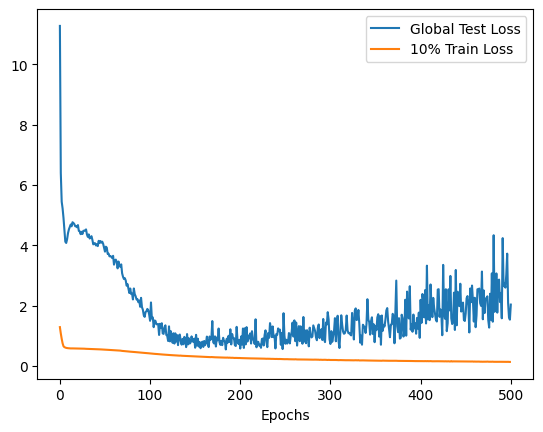

In [ ]:
# Plot train and test loss
plt.plot(trainloss10pMEAN, label='10% Train Loss')
plt.plot(testloss10pMEAN['global'], label='10% Test Loss')
plt.xlabel('Epochs')
plt.legend()

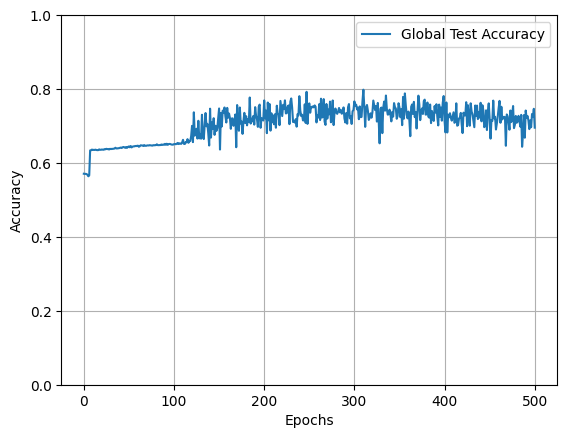

In [ ]:
# Plot test accuracy
plt.plot(testaccuracy10pMEAN['global'], label='Global Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()

# Set y-axis limits
plt.ylim(0, 1)

plt.legend()

### Confusion matrices

In [ ]:
# Make a confusion matrix for the test set
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Known to be true')
    plt.show()

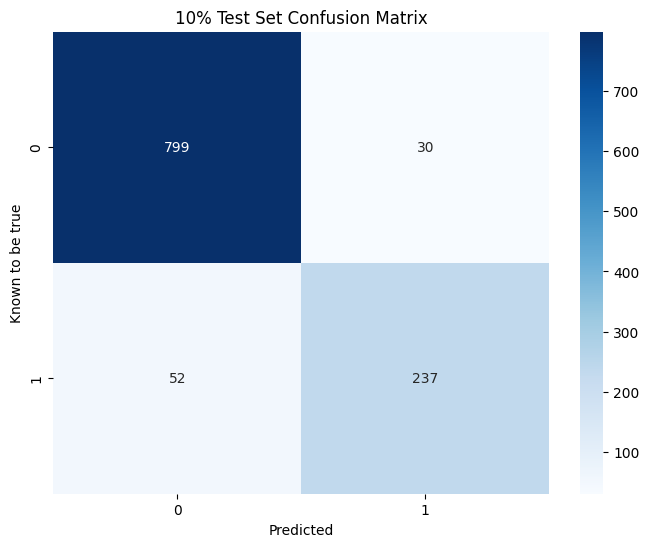

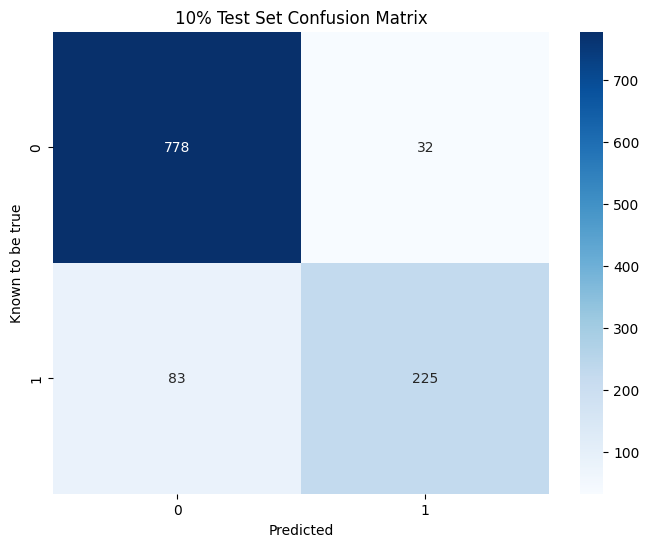

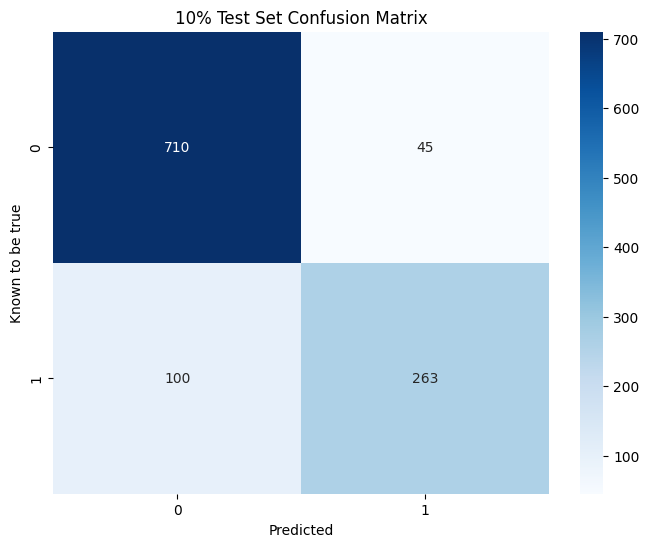

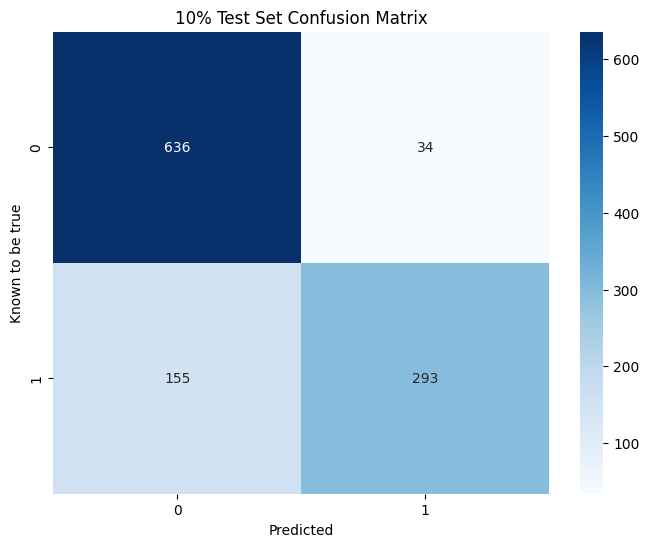

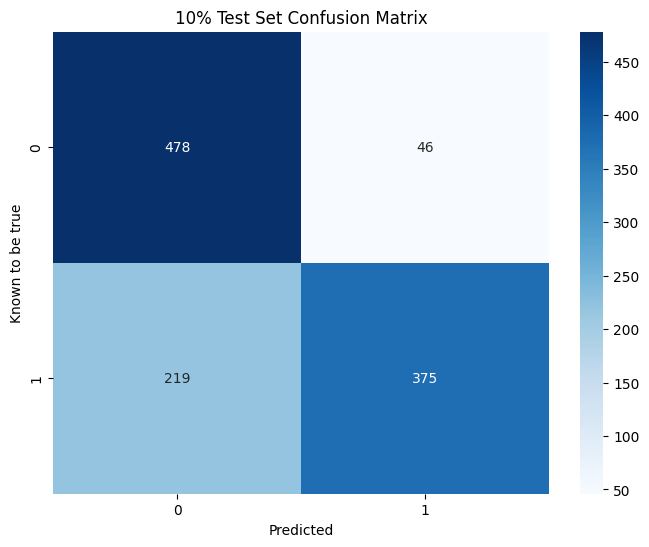

In [ ]:
for segmentation in splitSegmentations:
    X_test_total_tensor = torch.tensor(segmentation['X_test_total'], dtype=torch.float32)
    plot_confusion_matrix(segmentation['y_test_total'], net(X_test_total_tensor) >= 0.5, title='10% Test Set Confusion Matrix', labels=[0, 1])

## Train 50%

In [ ]:
# Train a network for each segmentation, and take the mean of the metrics
trainloss50pLIST = []
testloss50pLIST = []
testaccuracy50pLIST = []
for segmentation in dataloaderSegmentations:
    net = Net()

    trainloss50p, testloss50p, testaccuracy50p = trainAndEvaluateNetwork(net, epochs, segmentation['train_50p'], {"global": segmentation['test']}, lr, device)
    trainloss50pLIST.append(trainloss50p)
    testloss50pLIST.append(testloss50p)
    testaccuracy50pLIST.append(testaccuracy50p)

Initial global - Test Loss: 0.6096770652702876, Accuracy: 0.7245080500894454
Epoch 1/500 - Trainloss: 0.7367
global - Test Loss: 0.67334828547069, Accuracy: 0.6288014311270125
Epoch 2/500 - Trainloss: 0.6271
global - Test Loss: 0.6668230261121477, Accuracy: 0.6565295169946332
Epoch 3/500 - Trainloss: 0.6261
global - Test Loss: 0.6665196895599366, Accuracy: 0.6610017889087657
Epoch 4/500 - Trainloss: 0.6259
global - Test Loss: 0.6690259269305638, Accuracy: 0.6601073345259392
Epoch 5/500 - Trainloss: 0.6254
global - Test Loss: 0.6648315514836992, Accuracy: 0.6762075134168157
Epoch 6/500 - Trainloss: 0.6263
global - Test Loss: 0.6668022871017456, Accuracy: 0.6833631484794276
Epoch 7/500 - Trainloss: 0.6242
global - Test Loss: 0.6598757675715855, Accuracy: 0.7003577817531306
Epoch 8/500 - Trainloss: 0.6235
global - Test Loss: 0.6649349825722831, Accuracy: 0.6967799642218246
Epoch 9/500 - Trainloss: 0.6224
global - Test Loss: 0.6660274795123509, Accuracy: 0.7003577817531306
Epoch 10/500 - T

In [ ]:
testloss50pLISTglobal = list(map(lambda x: x['global'], testloss50pLIST))
testaccuracy50pLISTglobal = list(map(lambda x: x['global'], testaccuracy50pLIST))

trainloss50pMEAN = np.sum(np.array(trainloss50pLIST), axis=0) / len(trainloss50pLIST)
testloss50pMEAN = {"global": np.sum(np.array(testloss50pLISTglobal), axis=0) / len(testloss50pLISTglobal)}
testaccuracy50pMEAN = {"global": np.sum(np.array(testaccuracy50pLISTglobal), axis=0) / len(testaccuracy50pLISTglobal)}

### Plot the data

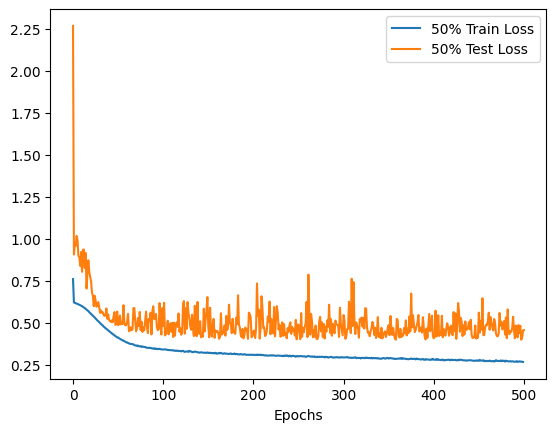

In [ ]:
# Plot train loss
plt.plot(trainloss50pMEAN, label='50% Train Loss')
plt.plot(testloss50pMEAN['global'], label='50% Test Loss')
plt.xlabel('Epochs')
plt.legend()

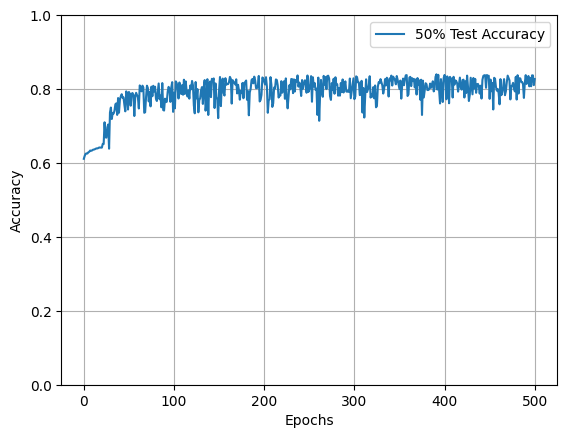

In [ ]:
# Plot test accuracy
plt.plot(testaccuracy50pMEAN['global'], label='50% Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

# Set y-axis limits
plt.ylim(0, 1)

plt.legend()

In [ ]:
X_test_total_tensor = torch.tensor(splitSegmentations['X_test_total'], dtype=torch.float32)
plot_confusion_matrix(splitSegmentations['y_test_total'], net(X_test_total_tensor) >= 0.5, title='50% Test Set Confusion Matrix', labels=[0, 1])

TypeError: list indices must be integers or slices, not str

## Train 100%

In [ ]:
# Train a network for each segmentation, and take the mean of the metrics
trainloss100pLIST = []
testloss100pLIST = []
testaccuracy100pLIST = []
for segmentation in dataloaderSegmentations:
    net = Net()

    trainloss100p, testloss100p, testaccuracy100p = trainAndEvaluateNetwork(net, epochs, segmentation['train_100p'], {"global": segmentation['test']}, lr, device)
    trainloss100pLIST.append(trainloss100p)
    testloss100pLIST.append(testloss100p)
    testaccuracy100pLIST.append(testaccuracy100p)

Initial global - Test Loss: 0.6455038266522544, Accuracy: 0.7415026833631485
Epoch 1/500 - Trainloss: 1.0814
global - Test Loss: 0.6798923867089408, Accuracy: 0.6592128801431127
Epoch 2/500 - Trainloss: 0.6844
global - Test Loss: 0.6848247289657593, Accuracy: 0.7334525939177102
Epoch 3/500 - Trainloss: 0.6798
global - Test Loss: 0.6740472282682146, Accuracy: 0.7844364937388193
Epoch 4/500 - Trainloss: 0.6752
global - Test Loss: 0.6721555863107954, Accuracy: 0.7915921288014311
Epoch 5/500 - Trainloss: 0.6732
global - Test Loss: 0.6471091764313834, Accuracy: 0.7522361359570662
Epoch 6/500 - Trainloss: 0.6668
global - Test Loss: 0.6541405081748962, Accuracy: 0.7737030411449016
Epoch 7/500 - Trainloss: 0.6653
global - Test Loss: 0.6396389075687954, Accuracy: 0.7620751341681574
Epoch 8/500 - Trainloss: 0.6625
global - Test Loss: 0.6485699585505894, Accuracy: 0.7996422182468694
Epoch 9/500 - Trainloss: 0.6538
global - Test Loss: 0.6206850988524301, Accuracy: 0.7602862254025045
Epoch 10/500 -

In [ ]:
testloss100pLISTglobal = list(map(lambda x: x['global'], testloss100pLIST))
testaccuracy100pLISTglobal = list(map(lambda x: x['global'], testaccuracy100pLIST))

trainloss100pMEAN = np.sum(np.array(trainloss100pLIST), axis=0) / len(trainloss100pLIST)
testloss100pMEAN = {"global": np.sum(np.array(testloss100pLISTglobal), axis=0) / len(testloss100pLISTglobal)}
testaccuracy100pMEAN = {"global": np.sum(np.array(testaccuracy100pLISTglobal), axis=0) / len(testaccuracy100pLISTglobal)}

### Plot the data

testloss100pMEAN['global'][-1]=np.float64(0.423492762531553)


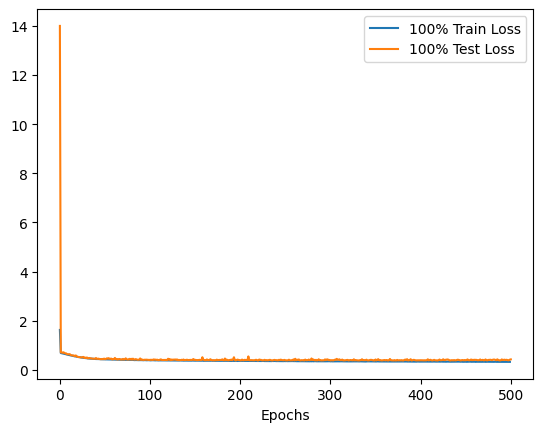

In [ ]:
# Plot train loss
plt.plot(trainloss100pMEAN, label='100% Train Loss')
plt.plot(testloss100pMEAN['global'], label='100% Test Loss')
plt.xlabel('Epochs')
plt.legend()

print(f"{testloss100pMEAN['global'][-1]=}")

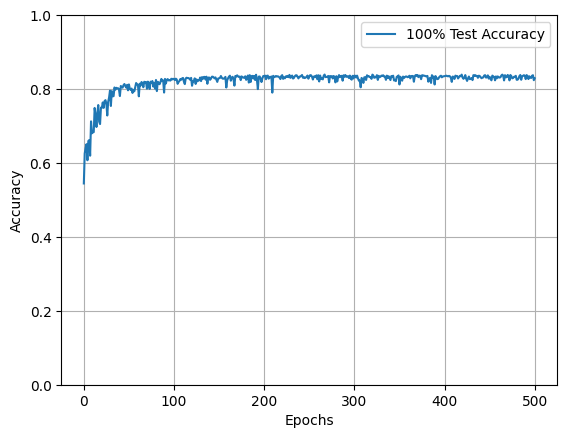

In [ ]:
# Plot test accuracy
plt.plot(testaccuracy100pMEAN['global'], label='100% Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

# Set y-axis limits
plt.ylim(0, 1)

plt.legend()

In [ ]:
X_test_total_tensor = torch.tensor(splitSegmentations['X_test_total'], dtype=torch.float32)
plot_confusion_matrix(splitSegmentations['X_test_total'], net(X_test_total_tensor) >= 0.5, title='100% Test Set Confusion Matrix', labels=[0, 1])

TypeError: list indices must be integers or slices, not str

# All Accuracies plotted together:

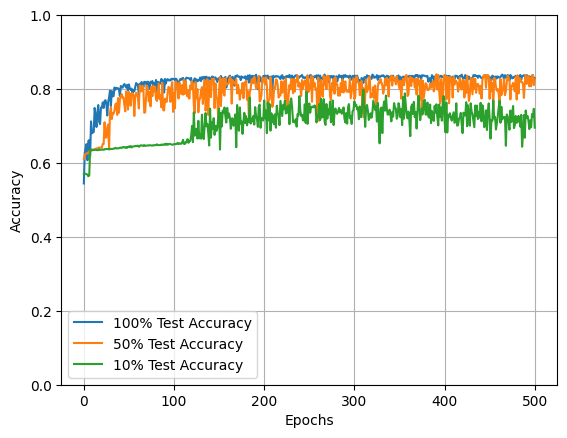

In [ ]:
# Plot test accuracy
plt.plot(testaccuracy100pMEAN['global'], label='100% Test Accuracy')
plt.plot(testaccuracy50pMEAN['global'], label='50% Test Accuracy')
plt.plot(testaccuracy10pMEAN['global'], label='10% Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

# Set y-axis limits
plt.ylim(0, 1)

plt.legend()

In [ ]:
print(f"{testaccuracy100pMEAN['global'][-1]=}")
print(f"{testaccuracy50pMEAN['global'][-1]=}")
print(f"{testaccuracy10pMEAN['global'][-1]=}")
print(f"{np.max(testaccuracy100pMEAN['global'])=}")
print(f"{np.max(testaccuracy50pMEAN['global'])=}")
print(f"{np.max(testaccuracy10pMEAN['global'])=}")

testaccuracy100pMEAN['global'][-1]=np.float64(0.8291592128801432)
testaccuracy50pMEAN['global'][-1]=np.float64(0.8270125223613596)
testaccuracy10pMEAN['global'][-1]=np.float64(0.6955277280858676)
np.max(testaccuracy100pMEAN['global'])=np.float64(0.8391771019677996)
np.max(testaccuracy50pMEAN['global'])=np.float64(0.8398926654740608)
np.max(testaccuracy10pMEAN['global'])=np.float64(0.7982110912343471)
